In [1]:
import uproot	
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import awkward as ak
from scipy.optimize import curve_fit
import mplhep
mplhep.style.use(["LHCbTex2"])

plt.rcParams["savefig.dpi"] = 600
%matplotlib inline

In [2]:
file = uproot.open(
    "/work/cetin/Projektpraktikum/trackinglosses_B_photon_cuts.root")

# selektiere nur elektronen von B->K*ee
allcolumns = []
for i in range(11):
    allcolumns.append(file["Tree" + str(i)].arrays())

In [3]:
allcolumns[1][1]

<Record {oneCut_event_id: 1, ...} type='{oneCut_event_id: int64, oneCut_los...'>

In [4]:
def cutdict():
    basedict = {
        "0": {},
        "1": {},
        "2": {},
        "3": {},
        "4": {},
        "5": {},
        "6": {},
        "7": {},
        "8": {},
        "9": {},
        "10": {},
    }

    basedict["0"] = "no"
    basedict["1"] = "one"
    basedict["2"] = "two"
    basedict["3"] = "three"
    basedict["4"] = "four"
    basedict["5"] = "five"
    basedict["6"] = "six"
    basedict["7"] = "seven"
    basedict["8"] = "eight"
    basedict["9"] = "nine"
    basedict["10"] = "ten"

    return basedict


Cuts = cutdict()

In [5]:
# electrons = []
# for jcut in range(11):

jcut = 4  # cut 0.2*E

energy_emissions = ak.ArrayBuilder()

for jelec in range(ak.num(allcolumns[jcut], axis=0)):
    energy_emissions.begin_record()
    energy_emissions.field("lost").boolean(
        allcolumns[jcut][jelec, Cuts[str(jcut)] + "Cut_" + "lost"])
    energy_emissions.field("rad_length_frac").real(
        allcolumns[jcut][jelec, Cuts[str(jcut)] + "Cut_" + "rad_length_frac"])
    energy_emissions.field("energy").real(
        allcolumns[jcut][jelec, Cuts[str(jcut)] + "Cut_" + "energy"])

    tmp_velo = 0
    tmp_richut = 0
    tmp_neither = 0
    tmp_velo_length = 0
    tmp_richut_length = 0
    tmp_neither_length = 0

    for jphoton in range(
            ak.num(
                allcolumns[jcut][jelec][Cuts[str(jcut)] + "Cut_" +
                                        "brem_photons_pe"],
                axis=0,
            )):
        if (allcolumns[jcut][jelec, Cuts[str(jcut)] + "Cut_" + "brem_vtx_z",
                             jphoton] <= 770):
            tmp_velo += allcolumns[jcut][jelec, Cuts[str(jcut)] + "Cut_" +
                                         "brem_photons_pe", jphoton]
            tmp_velo_length += 1
        elif (allcolumns[jcut][jelec, Cuts[str(jcut)] + "Cut_" + "brem_vtx_z",
                               jphoton]
              > 770) and (allcolumns[jcut][jelec, Cuts[str(jcut)] + "Cut_" +
                                           "brem_vtx_z", jphoton] <= 2700):
            tmp_richut += allcolumns[jcut][jelec, Cuts[str(jcut)] + "Cut_" +
                                           "brem_photons_pe", jphoton]
            tmp_richut_length += 1
        else:
            tmp_neither += allcolumns[jcut][jelec, Cuts[str(jcut)] + "Cut_" +
                                            "brem_photons_pe", jphoton]
            tmp_neither_length += 1

    energy_emissions.field("velo_length").integer(tmp_velo_length)
    energy_emissions.field("velo").real(tmp_velo)

    energy_emissions.field("rich_length").integer(tmp_richut_length)
    energy_emissions.field("rich").real(tmp_richut)

    energy_emissions.field("neither_length").integer(tmp_neither_length)
    energy_emissions.field("downstream").real(tmp_neither)

    energy_emissions.field("photon_length").integer(tmp_richut_length +
                                                    tmp_velo_length)

    if ((tmp_velo == 0) and (tmp_richut == 0)
            or (allcolumns[jcut][jelec, Cuts[str(jcut)] + "Cut_" + "energy"] -
                tmp_velo < 3000)):
        energy_emissions.field("quality").integer(0)
    else:
        energy_emissions.field("quality").integer(1)

    energy_emissions.end_record()

energy_emissions = ak.Array(energy_emissions)
# electrons.append(energy_emissions)

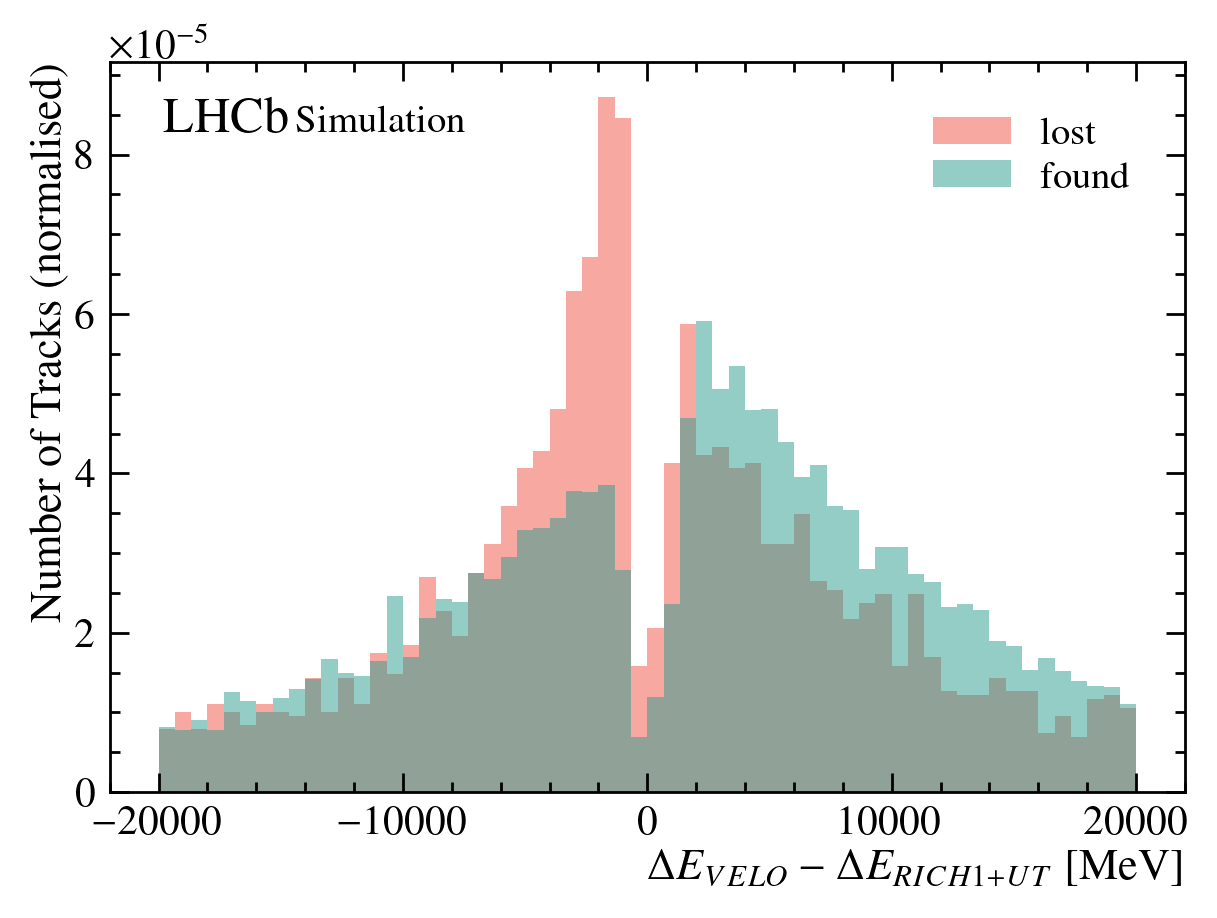

In [6]:
velo_found = ak.to_numpy(
    energy_emissions[(~energy_emissions.lost)
                     & (energy_emissions.quality == 1)]["velo"])
rich_found = ak.to_numpy(
    energy_emissions[(~energy_emissions.lost)
                     & (energy_emissions.quality == 1)]["rich"])
energy_found = ak.to_numpy(
    energy_emissions[(~energy_emissions.lost)
                     & (energy_emissions.quality == 1)]["energy"])

velo_lost = ak.to_numpy(
    energy_emissions[(energy_emissions.lost)
                     & (energy_emissions.quality == 1)]["velo"])
rich_lost = ak.to_numpy(
    energy_emissions[(energy_emissions.lost)
                     & (energy_emissions.quality == 1)]["rich"])
energy_lost = ak.to_numpy(
    energy_emissions[(energy_emissions.lost)
                     & (energy_emissions.quality == 1)]["energy"])

diff_found = velo_found - rich_found
diff_lost = velo_lost - rich_lost

xlim = 20000
nbins = 60

plt.hist(
    diff_lost,
    bins=nbins,
    density=True,
    alpha=0.5,
    histtype="bar",
    color="#F05342",
    label="lost",
    range=[-xlim, xlim],
)
plt.hist(
    diff_found,
    bins=nbins,
    density=True,
    alpha=0.5,
    histtype="bar",
    color="#2A9D8F",  # "#107E7D",
    label="found",
    range=[-xlim, xlim],
)
# plt.xlim(-20000, 20000)
# plt.yscale("log")
# plt.title("emitted energy difference")
plt.xlabel(r"$\Delta E_{VELO} - \Delta E_{RICH1+UT}$ [MeV]")
plt.ylabel("Number of Tracks (normalised)")
plt.legend(loc="best")
mplhep.lhcb.text("Simulation")
# plt.show()
plt.savefig(
    "/work/cetin/Projektpraktikum/thesis/emitted_energy_difference.pdf",
    format="PDF")

nbins = 6
quality_cut = electrons[jcut].quality != -1

### all split in velo and rich

fig, axs = plt.subplots(3, 3, figsize=(15, 6))
ax = axs.ravel()
for jcut, ax in enumerate(ax):
ax.hist(
ak.to_numpy(electrons[jcut][quality_cut]["velo_length"]),
bins=nbins,
density=True,
alpha=0.5,
color="darkorange",
histtype="bar",
label="velo",
range=[0, nbins],
)
ax.hist(
ak.to_numpy(electrons[jcut][quality_cut]["rich_length"]),
bins=nbins,
density=True,
alpha=0.5,
color="blue",
histtype="bar",
label="rich",
range=[0, nbins],
)
ax.set_xlim(0, nbins)
ax.set_ylim(0, 1)
ax.set_title("Photon Cut: " + str(np.round(jcut \* 0.05, 2)) + f"$E_0$")
ax.set_xlabel("number of photons")
ax.set_ylabel("a.u.")
plt.suptitle("number of photons in velo and rich")
plt.legend()
plt.tight_layout()
plt.show()

### found

fig, axs = plt.subplots(3, 3, figsize=(15, 6))
ax = axs.ravel()
for jcut, ax in enumerate(ax):
ax.hist(
ak.to_numpy(
electrons[jcut]~(electrons[jcut].lost) & quality_cut]["velo_length"]
),
bins=nbins,
density=True,
alpha=0.5,
color="darkorange",
histtype="bar",
label="velo",
range=[0, nbins],
)
ax.hist(
ak.to_numpy(
electrons[jcut]~(electrons[jcut].lost) & quality_cut]["rich_length"]
),
bins=nbins,
density=True,
alpha=0.5,
color="blue",
histtype="bar",
label="rich",
range=[0, nbins],
)
ax.set_xlim(0, nbins)
ax.set_ylim(0, 1)
ax.set_title("Photon Cut: " + str(np.round(jcut \* 0.05, 2)) + f"$E_0$")
ax.set_xlabel("number of photons")
ax.set_ylabel("a.u.")
plt.suptitle("number of photons of found electrons")
plt.legend()
plt.tight_layout()
plt.show()

### lost

fig, axs = plt.subplots(3, 3, figsize=(15, 6))
ax = axs.ravel()
for jcut, ax in enumerate(ax):
ax.hist(
ak.to_numpy(
electrons[jcut](electrons[jcut].lost) & quality_cut]["velo_length"]
),
bins=nbins,
density=True,
alpha=0.5,
color="darkorange",
histtype="bar",
label="velo",
range=[0, nbins],
)
ax.hist(
ak.to_numpy(
electrons[jcut](electrons[jcut].lost) & quality_cut]["rich_length"]
),
bins=nbins,
density=True,
alpha=0.5,
color="blue",
histtype="bar",
label="rich",
range=[0, nbins],
)
ax.set_xlim(0, nbins)
ax.set_ylim(0, 1)
ax.set_title("Photon Cut: " + str(np.round(jcut \* 0.05, 2)) + f"$E_0$")
ax.set_xlabel("number of photons")
ax.set_ylabel("a.u.")
plt.suptitle("number of photons of lost electrons")
plt.legend()
plt.tight_layout()
plt.show()
quality_cut = electrons[jcut].quality != -1

### all split in lost and found

fig, axs = plt.subplots(3, 3, figsize=(15, 6))
ax = axs.ravel()
for jcut, ax in enumerate(ax):
ax.hist(
ak.to_numpy(
electrons[jcut](electrons[jcut].lost) & (quality_cut)]["photon_length"]
),
bins=10,
density=True,
alpha=0.5,
color="darkorange",
histtype="bar",
label="lost",
range=[0, 10],
)
ax.hist(
ak.to_numpy(
electrons[jcut](~electrons[jcut].lost) & (quality_cut)]["photon_length"]
),
bins=10,
density=True,
alpha=0.5,
color="blue",
histtype="bar",
label="found",
range=[0, 10],
)
ax.set_xlim(0, 10) # ax.set_ylim(0,1) # ax.set_yscale('log')
ax.set_title("Photon Cut: " + str(np.round(jcut \* 0.05, 2)) + f"$E_0$")
ax.set_xlabel("number of photons")
ax.set_ylabel("a.u.")
plt.suptitle("number of photons in lost and found")
plt.legend()
plt.tight_layout()
plt.show()
